# DataScience/Week 5

### Introducion

In this sudy, we will examine the characteristic of each town and which part of Singapore should a recreational business start. Recreational business owner will be interested in this project.

For Data, we will use list of Towns in Singapore by using Wikipedia. We will examine the following features of town:
- what are their most common spot in each town
- What is the distribution of nature of business

We will make use of Foursquare location data to further understand the pattern/behavior of  locals and competition level in the country. We will also use OneMap API to obtain the location cooridnates of each town in Singapore. 

A location shall be recommended based on:
1. Competition within Town
2. Location
3. Behaviour of customer -- interest level by the general public

In [1]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen

In [2]:
import json

### Methodology

We use python beautiful soup library to extract the data from wikipedia

In [3]:
url = 'https://en.wikipedia.org/wiki/New_towns_of_Singapore'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')

In [4]:
soup = soup.find_all("table")

In [5]:
Town = []

for table in soup:
    rows = table.find_all('tr')
    
    for row in rows:
        cells = row.find_all('td')
        
        if len(cells) > 0:
            x = cells[0]
            Town.append(x.text.strip())
            

In [6]:
len(Town)

30

In [7]:
Town = Town[:26]

Now we use Onemap API to obtain the coordinates and fill up those town with missing coordinates

In [8]:
town_lat = []
town_long = []

for i in range(0, len(Town)):
    query_address = Town[i]
    query_string = 'https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
    resp = requests.get(query_string)

    data_town=json.loads(resp.content.decode('utf-8'))
    
    if data_town['found'] != 0:
        town_lat.append(data_town["results"][0]["LATITUDE"])
        town_long.append(data_town["results"][0]["LONGITUDE"])

        print (str(query_address)+",Lat: "+data_town['results'][0]['LATITUDE'] +" Long: "+data_town['results'][0]['LONGITUDE'])

    else:
        town_lat.append('NotFound')
        town_long.append('NotFound')
        print ("No Results")

Ang Mo Kio,Lat: 1.369955509 Long: 103.8466998
Bedok,Lat: 1.323682017 Long: 103.9477893
Bishan,Lat: 1.347306941 Long: 103.85241490000001
Bukit Batok,Lat: 1.3493675019999998 Long: 103.7453474
Bukit Merah,Lat: 1.279256199 Long: 103.82720929999999
Bukit Panjang,Lat: 1.377507276 Long: 103.7736056
Choa Chu Kang,Lat: 1.4040773880000001 Long: 103.7489021
Clementi,Lat: 1.323376648 Long: 103.7740173
Geylang,Lat: 1.312893362 Long: 103.887635
Hougang,Lat: 1.379943836 Long: 103.8874655
Jurong East,Lat: 1.340639044 Long: 103.7424745
Jurong West,Lat: 1.341603266 Long: 103.70808520000001
No Results
Pasir Ris,Lat: 1.3815451619999999 Long: 103.9455095
Punggol,Lat: 1.4054135369999998 Long: 103.8968239
Queenstown,Lat: 1.294250313 Long: 103.8061795
Sembawang,Lat: 1.4613616269999998 Long: 103.8365005
Sengkang,Lat: 1.383153805 Long: 103.8923817
Serangoon,Lat: 1.344892015 Long: 103.8712522
Tampines,Lat: 1.344593928 Long: 103.9475126
Toa Payoh,Lat: 1.337007933 Long: 103.8428502
Woodlands,Lat: 1.415205915 Long:

In [9]:
df = pd.DataFrame({'Town': Town,'latitude': town_lat,'longitude':town_long})

In [10]:
df[df['latitude']=='NotFound']

,Town,latitude,longitude
12,Kallang/Whampoa,NotFound,NotFound
25,Central Area,NotFound,NotFound


In [11]:
df.iloc[12,1] = "1.3069"
df.iloc[12,2] = "103.8695"
df.iloc[25,1] = "1.287953"
df.iloc[25,2] = "103.851784"

We have gotten a complete table of town with Latitude and Longitude

In [12]:
df

,Town,latitude,longitude
0,Ang Mo Kio,1.369955509,103.8466998
1,Bedok,1.323682017,103.9477893
2,Bishan,1.347306941,103.85241490000001
3,Bukit Batok,1.3493675019999998,103.7453474
4,Bukit Merah,1.279256199,103.82720929999999
5,Bukit Panjang,1.377507276,103.7736056
6,Choa Chu Kang,1.4040773880000001,103.7489021
7,Clementi,1.323376648,103.7740173
8,Geylang,1.312893362,103.887635
9,Hougang,1.379943836,103.8874655


In [13]:
# Foursquare API credential

We set limit to be 1000 and Radius to be 600 in this case so that more results can be captured. We create API to obtain all information from Foursquare

In [14]:
limit = 1000
Radius = 600

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
df_venues = getNearbyVenues(names=df['Town'],latitudes=df['latitude'],longitudes=df['longitude'])

Ang Mo Kio
Bedok
Bishan
Bukit Batok
Bukit Merah
Bukit Panjang
Choa Chu Kang
Clementi
Geylang
Hougang
Jurong East
Jurong West
Kallang/Whampoa
Pasir Ris
Punggol
Queenstown
Sembawang
Sengkang
Serangoon
Tampines
Toa Payoh
Woodlands
Yishun
Bukit Timah
Marine Parade
Central Area


In [17]:
df_venues.shape

(734, 7)

All common venues based on all towns in Singapore have been obtained and all data have been tabulated as below

In [18]:
df_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,1.369955509,103.8466998,Old Chang Kee,1.369094,103.848389,Snack Place
1,Ang Mo Kio,1.369955509,103.8466998,MOS Burger,1.369170,103.847831,Burger Joint
2,Ang Mo Kio,1.369955509,103.8466998,FairPrice Xtra,1.369279,103.848886,Supermarket
3,Ang Mo Kio,1.369955509,103.8466998,Face Ban Mian 非板面 (Ang Mo Kio),1.372031,103.847504,Noodle House
4,Ang Mo Kio,1.369955509,103.8466998,NTUC FairPrice,1.371507,103.847082,Supermarket


### Analysis on Data 

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Let us see how many venues/results in each town

In [20]:
df_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ang Mo Kio,51,51,51,51,51,51
Bedok,10,10,10,10,10,10
Bishan,45,45,45,45,45,45
Bukit Batok,27,27,27,27,27,27
Bukit Merah,18,18,18,18,18,18
Bukit Panjang,9,9,9,9,9,9
Bukit Timah,57,57,57,57,57,57
Central Area,100,100,100,100,100,100
Choa Chu Kang,11,11,11,11,11,11


Let us formulate a table on which are the most common area where Singaporeans like to go in each town. First, we create a table to count the occurences of each venue, then we take a mean in each town. Then we use the function to tabulate each 5 common spaces in each town.

In [21]:
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Neighborhood'] = df_venues['Neighborhood'] 
cols = list(df_onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
df_onehot = df_onehot.ix[:, cols]

C:\Users\SONY\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [22]:
df_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bank,Bar,...,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df_onehot.shape

(734, 164)

In [24]:
df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()

In [25]:
num_top_venues = 5

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df_grouped['Neighborhood']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ang Mo Kio,Food Court,Coffee Shop,Dessert Shop,Bubble Tea Shop,Japanese Restaurant
1,Bedok,Pool,Basketball Court,Bus Line,Flower Shop,Noodle House
2,Bishan,Food Court,Coffee Shop,Chinese Restaurant,Bubble Tea Shop,Ice Cream Shop
3,Bukit Batok,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Food Court,Shopping Mall
4,Bukit Merah,Asian Restaurant,Bookstore,Café,Coffee Shop,Restaurant


Based on graph below, it shows that Coffee shop and Food Court are amognst the most common places Singaporean go.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

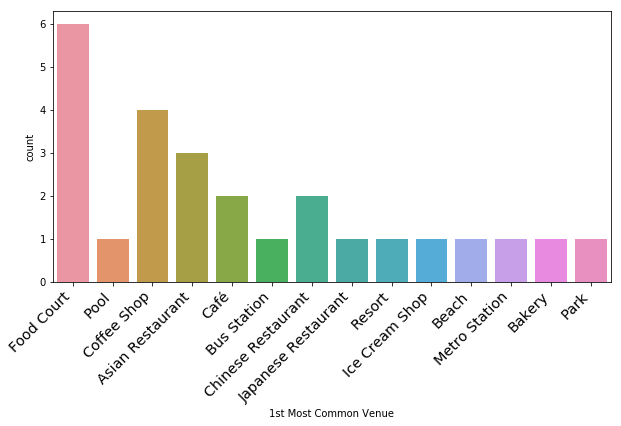

In [28]:
plt.figure(figsize=(10,5))
chart = sns.countplot(x='1st Most Common Venue',data=neighborhoods_venues_sorted)
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')

In [29]:
from sklearn.cluster import KMeans

In [30]:
from yellowbrick.cluster import KElbowVisualizer

We make use of K-means clustering to form cluster such that we can better understand the distribution of each cluster across Singapore. By using the elbow method, we find the optimal K value. Dividing the data into 3 cluster is the optimal option in this case.

In [31]:
df_grouped_clustering = df_grouped.drop('Neighborhood', 1)

In [59]:
model = KMeans(random_state=0)

In [64]:
visualiser = KElbowVisualizer(model, k=(1,12))

C:\Users\SONY\AppData\Roaming\Python\Python35\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\SONY\AppData\Roaming\Python\Python35\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000000116B95C0>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

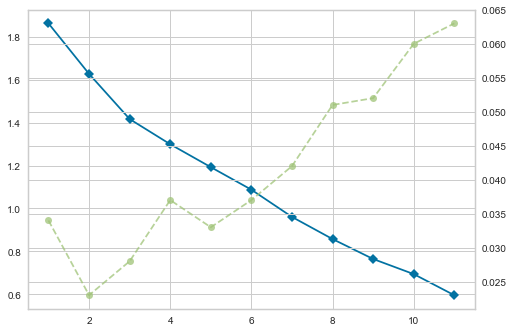

In [65]:
visualiser.fit(df_grouped_clustering)

In [58]:
visualiser.show()  #lowest distortion score distance from each point between each assigned centroid

Thus, we will divide the data into 3 clusters.

In [36]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [37]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [38]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Ang Mo Kio,Food Court,Coffee Shop,Dessert Shop,Bubble Tea Shop,Japanese Restaurant
1,0,Bedok,Pool,Basketball Court,Bus Line,Flower Shop,Noodle House
2,0,Bishan,Food Court,Coffee Shop,Chinese Restaurant,Bubble Tea Shop,Ice Cream Shop
3,0,Bukit Batok,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Food Court,Shopping Mall
4,0,Bukit Merah,Asian Restaurant,Bookstore,Café,Coffee Shop,Restaurant


In [39]:
df.rename(columns={'Town': 'Neighborhood'}, inplace=True)

In [40]:
df_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [41]:
df_merged.head()

,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ang Mo Kio,1.369955509,103.8466998,0,Food Court,Coffee Shop,Dessert Shop,Bubble Tea Shop,Japanese Restaurant
1,Bedok,1.323682017,103.9477893,0,Pool,Basketball Court,Bus Line,Flower Shop,Noodle House
2,Bishan,1.347306941,103.85241490000001,0,Food Court,Coffee Shop,Chinese Restaurant,Bubble Tea Shop,Ice Cream Shop
3,Bukit Batok,1.3493675019999998,103.7453474,0,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Food Court,Shopping Mall
4,Bukit Merah,1.279256199,103.82720929999999,0,Asian Restaurant,Bookstore,Café,Coffee Shop,Restaurant


Let us now examine what are the distinct feasture of each cluster

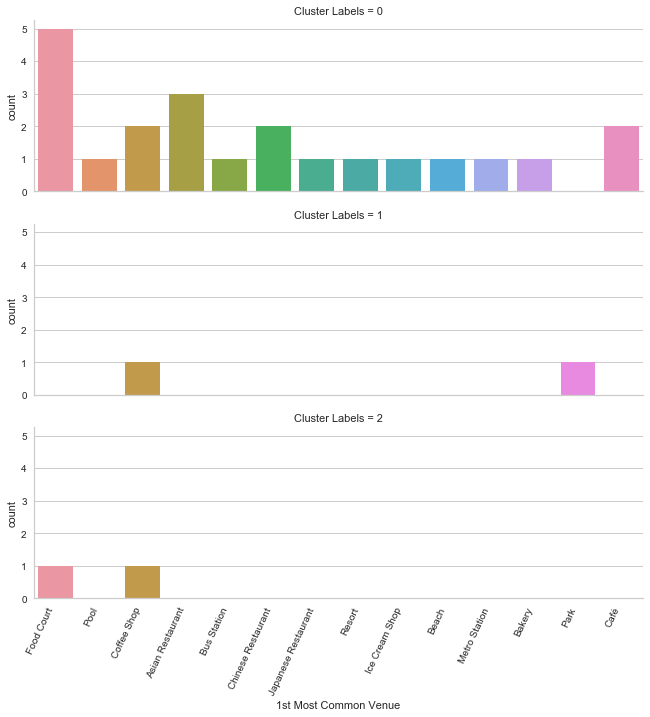

In [42]:
plt.figure(figsize=(10,5))
chart = sns.catplot(x='1st Most Common Venue',kind = 'count',row = 'Cluster Labels',data=df_merged[df_merged['Cluster Labels'].isin([0,1,2])],aspect = 3,height =3)
for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')

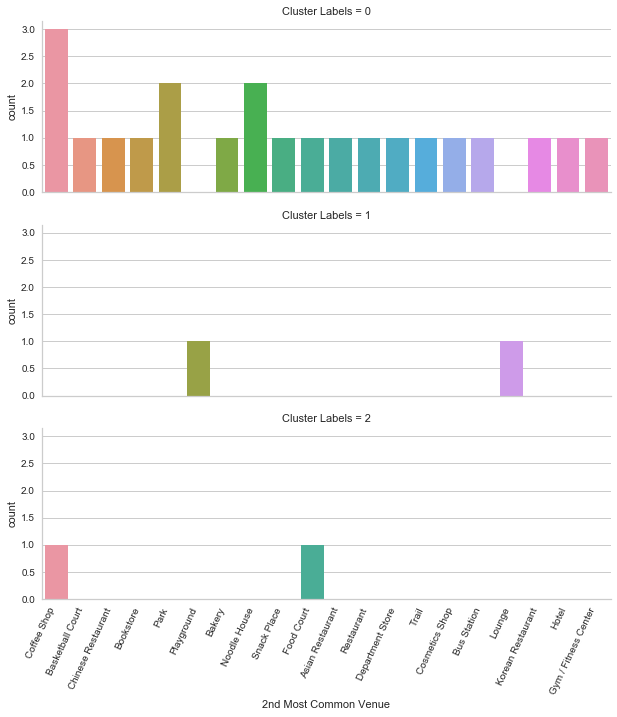

In [43]:
plt.figure(figsize=(10,5))
chart = sns.catplot(x='2nd Most Common Venue',kind = 'count',row = 'Cluster Labels',data=df_merged[df_merged['Cluster Labels'].isin([0,1,2])],aspect = 3,height =3)
for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')

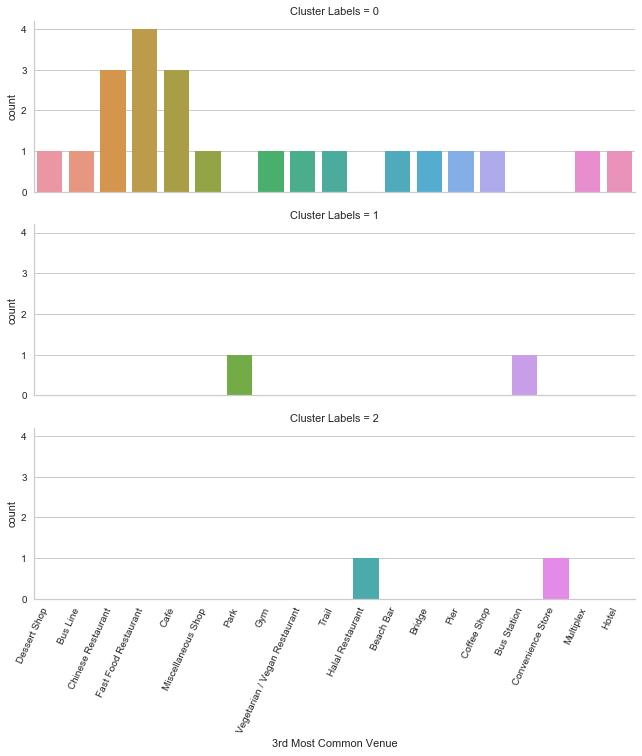

In [44]:
plt.figure(figsize=(10,5))
chart = sns.catplot(x='3rd Most Common Venue',kind = 'count',row = 'Cluster Labels',data=df_merged[df_merged['Cluster Labels'].isin([0,1,2])],aspect = 3,height =3)
for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')

Based on graph above, we see that

1. Cluster 1 -- Leisure and recreational activities
2. Cluster 2 -- Shopping and food such as coffee shop, Dessert shop etc.
3. Cluster 3 -- Transportation and convenience store

In [45]:
import folium 
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import display

In [46]:
address = 'Singapore'

geolocator = Nominatim(user_agent="sg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore are 1.357107, 103.8194992.


In [47]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

In [48]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['latitude'], df_merged['longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('map_clusters_sg.html')
# Import the Folium interactive html file


from IPython.display import HTML
HTML('<iframe src=map_clusters_sg.html width=700 height=450></iframe>')

In [49]:
len(df_venues['Venue Category'].unique())

164

### Discussion

The above second graph has given us an insight on overview of venues for each cluster,therefore In overall, we have 3 main clusters:
1. Cluster 1 -- Leisure and recreational activities
2. Cluster 2 -- Shopping and food such as coffee shop, Dessert shop etc.
3. Cluster 3 -- Transportation and convenience store

This is relatively true that Singaporean loves to go Food Court and coffee shop, all 3 cluster reflects this phenomenon. On the other hand, what makes them distinct from one another are highly determined by 2nd and 3rd most common places instead. 

We observed that based on the map above, cluster 2 which represented by purple dots is mostly residential area and central area and where most shipping and eatery are located. Cluster 1 which represented by red dots is located near nature reserves such as Bukit Timah nature reserve and zoos. 
    


### Conclusion

We can see that recreational facilities and parks are concentrated in north-west area of Singapore. Competition is high in the mentioned area. Based on data collected, almost all cluster first common places are food court and coffee shop. Food Court usually comes together with shopping centres. Recreational owner may want to explore business in small scale and incorporate the idea in shopping malls.